# Use Case: Kindergarten Capacity Forecasting for Preschool-Aged Children  

**Authored by:** Muzamil Rafique  
**Duration:** ~60 mins  
**Level:** Intermediate  
**Pre-requisite Skills:** Python (pandas, requests), basic data cleaning & plotting  

---

## Scenario  
_As a city planning analyst_, I compare the projected number of **0–4 year-olds** in 2040 with today’s supply of childcare centres by suburb. This highlights which suburbs may face **future capacity pressure** if no new centres are added. By measuring children per centre, I can identify **fast-growing areas** most in need of new childcare facilities.  

---

## Datasets Used  
**City of Melbourne – Population Forecasts by Small Area (2020–2040, API v2.1)**  
Population forecasts broken down by suburb and age group. Used here to extract **Age 0–4** counts for **2023** and **2040**. Accessed via the public CSV export endpoint.  

**Childcare Centres (project dataset)**  
Geocoded records of registered childcare centres, used to compute **centre counts per suburb**. Suburb names are standardised to match the demand dataset, allowing direct comparison and pressure calculations.  

---

## What this use case will teach you  
- How to load data from the **City of Melbourne Open Data API v2.1 (exports)**  
- How to load and clean a second dataset of childcare centres  
- How to filter and summarise population forecasts (Age 0–4, 2023 vs 2040)  
- How to calculate future demand pressure (children per centre) and visualise top suburbs   


In [33]:
# --- Imports ---
import os
import requests
import pandas as pd
from io import StringIO
import csv
import folium
from folium.plugins import HeatMap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import ipywidgets as widgets
from IPython.display import display, clear_output
from geopy.geocoders import Nominatim
from geopy.distance import geodesic

import warnings
warnings.filterwarnings("ignore")

## 1) Helper Function – API v2.1 Loader  

This function fetches datasets from the **City of Melbourne Open Data Portal** using the `exports/csv`  
endpoint of API v2.1.  

- Accepts the dataset ID (slug from the portal)  
- Uses API key stored in environment variables (not hard-coded)  
- Returns a pandas DataFrame  


In [34]:
def fetch_mop_dataset_v21(dataset_id, select="*", limit=-1, lang="en", timezone="UTC"):
    """
    Fetch a dataset from City of Melbourne Open Data (API v2.1) using 'exports/csv'.
    Auto-detects delimiter for safer parsing. No API key required.
    """
    base = "https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets"
    url = f"{base}/{dataset_id}/exports/csv"

    params = {
        "select": select,
        "limit": limit,
        "lang": lang,
        "timezone": timezone,
    }

    r = requests.get(url, params=params)
    r.raise_for_status()

    # Auto-detect delimiter
    sample = r.text[:2000]
    dialect = csv.Sniffer().sniff(sample)
    df = pd.read_csv(StringIO(r.text), delimiter=dialect.delimiter)

    print(f"✅ Loaded {len(df):,} rows × {len(df.columns)} cols (delimiter='{dialect.delimiter}') from {dataset_id}")
    return df


## 2) Load Datasets  

We now load:  
- **Supply dataset (Childcare Centres)** → from GitHub raw CSV  
- **Demand dataset (Population Forecasts)** → from API v2.1  


In [35]:
# --- Supply (Childcare centres) from local repo file ---
supply_df = pd.read_csv("geocoded_output.csv", delimiter=",")
print("Supply dataset shape:", supply_df.shape)

# --- Demand (Population forecasts) via API v2.1 ---
pop_dataset_id = "city-of-melbourne-population-forecasts-by-small-area-2020-2040"
demand_df_raw = fetch_mop_dataset_v21(pop_dataset_id)

print(demand_df_raw.head())

Supply dataset shape: (4943, 11)
✅ Loaded 10,584 rows × 5 cols (delimiter=';') from city-of-melbourne-population-forecasts-by-small-area-2020-2040
  geography  year  gender        age  value
0   Carlton  2023  Female  Age 65-69    224
1   Carlton  2023  Female    Age 85+     66
2   Carlton  2024  Female  Age 25-29   2105
3   Carlton  2024  Female  Age 30-34   1174
4   Carlton  2024    Male  Age 25-29   1978


## 3) Clean Population Forecasts
Steps:
- Harmonise suburb names (fix mismatches, combine splits, drop duplicates)
- Clean and aggregate supply dataset (childcare centres per suburb)
- Process population forecasts (convert numeric, filter 0–4 yrs, extract 2023 & 2040, add metrics)


### 3.1 Harmonise Suburb Names
- Fix mismatches (e.g., CITY OF MELBOURNE → MELBOURNE)  
- Combine split suburbs (e.g., WEST MELBOURNE INDUSTRIAL + RESIDENTIAL → WEST MELBOURNE)  
- Drop duplicates (e.g., MELBOURNE CBD, MELBOURNE REMAINDER)  


In [36]:
# --- Harmonise suburb names ---
rename_map = {
    "CITY OF MELBOURNE": "MELBOURNE",
    "WEST MELBOURNE (INDUSTRIAL)": "WEST MELBOURNE",
    "WEST MELBOURNE (RESIDENTIAL)": "WEST MELBOURNE"
}

demand_df_raw["geography"] = (
    demand_df_raw["geography"].astype(str).str.strip().str.upper().replace(rename_map)
)

supply_df["Suburb"] = (
    supply_df["Suburb"].astype(str).str.strip().str.upper().replace(rename_map)
)

demand_df_raw = demand_df_raw[
    ~demand_df_raw["geography"].isin(["MELBOURNE (CBD)", "MELBOURNE (REMAINDER)"])
]


In [37]:
demand_df_raw["geography"] = demand_df_raw["geography"].replace({"MELBOURNE": "MELBOURNE CBD"})
supply_df["Suburb"] = supply_df["Suburb"].replace({"MELBOURNE": "MELBOURNE CBD"})


### 3.2 Clean Supply Data
- Standardise suburb names  
- Aggregate childcare centres per suburb → `CentreCount`  


In [38]:
centre_counts = supply_df.groupby("Suburb").size().reset_index(name="CentreCount")

### 3.3 Process Population Forecasts
- Convert `year` and `value` to numeric  
- Filter to **Age 0–4 only**  
- Aggregate for **2023** and **2040**  
- Merge demand + supply  
- Add metrics:  
  - Centres per 1000 Children  
  - Growth % (2023 → 2040)  
  - Future Pressure (children per centre in 2040)  


In [39]:
# Ensure numeric
for col in ("year", "value"):
    demand_df_raw[col] = pd.to_numeric(demand_df_raw[col], errors="coerce")

# Filter Age 0–4
df_0_4 = demand_df_raw[demand_df_raw["age"] == "Age 0-4"].copy()

# Populations
pop_2023 = (
    df_0_4[df_0_4["year"] == 2023.0]
    .groupby("geography", as_index=False)["value"].sum()
    .rename(columns={"geography": "Suburb", "value": "Pop2023"})
)
pop_2040 = (
    df_0_4[df_0_4["year"] == 2040.0]
    .groupby("geography", as_index=False)["value"].sum()
    .rename(columns={"geography": "Suburb", "value": "Pop2040"})
)

# Merge with supply
merged_df = pd.merge(pop_2023, pop_2040, on="Suburb", how="outer")
merged_df = pd.merge(merged_df, centre_counts, on="Suburb", how="left").fillna({"CentreCount": 0})

# Metrics
merged_df["Centres_per_1000_Children"] = (merged_df["CentreCount"] / merged_df["Pop2023"]) * 1000
merged_df["Growth_%"] = ((merged_df["Pop2040"] - merged_df["Pop2023"]) / merged_df["Pop2023"]) * 100
merged_df["Future_Pressure"] = merged_df["Pop2040"] / merged_df["CentreCount"].replace(0, pd.NA)

print("✅ Cleaned demand + supply merged with metrics")
display(merged_df.head(15))



✅ Cleaned demand + supply merged with metrics


,Suburb,Pop2023,Pop2040,CentreCount,Centres_per_1000_Children,Growth_%,Future_Pressure
0,CARLTON,412,868,10,24.271845,110.679612,86.800000
1,DOCKLANDS,797,1888,7,8.782936,136.888331,269.714286
2,EAST MELBOURNE,112,237,2,17.857143,111.607143,118.500000
3,KENSINGTON,709,1578,5,7.052186,122.566996,315.600000
4,MELBOURNE CBD,4762,11498,11,2.309954,141.453171,1045.272727
5,NORTH MELBOURNE,506,1472,10,19.762846,190.909091,147.200000
6,PARKVILLE,296,594,5,16.891892,100.675676,118.800000
7,PORT MELBOURNE,0,76,7,inf,inf,10.857143
8,SOUTH YARRA,100,208,9,90.000000,108.000000,23.111111
9,SOUTHBANK,574,1436,6,10.452962,150.174216,239.333333


### Insight 1: Projected Child Population Growth (0–4 yrs)

We merge the 2023 and 2040 population data for children aged 0–4.  
New columns are created for **absolute growth** and **percentage growth**.  
Suburbs are sorted by absolute growth to find the largest increases.  
A bar chart is plotted to compare 2023 and 2040 populations side by side.  


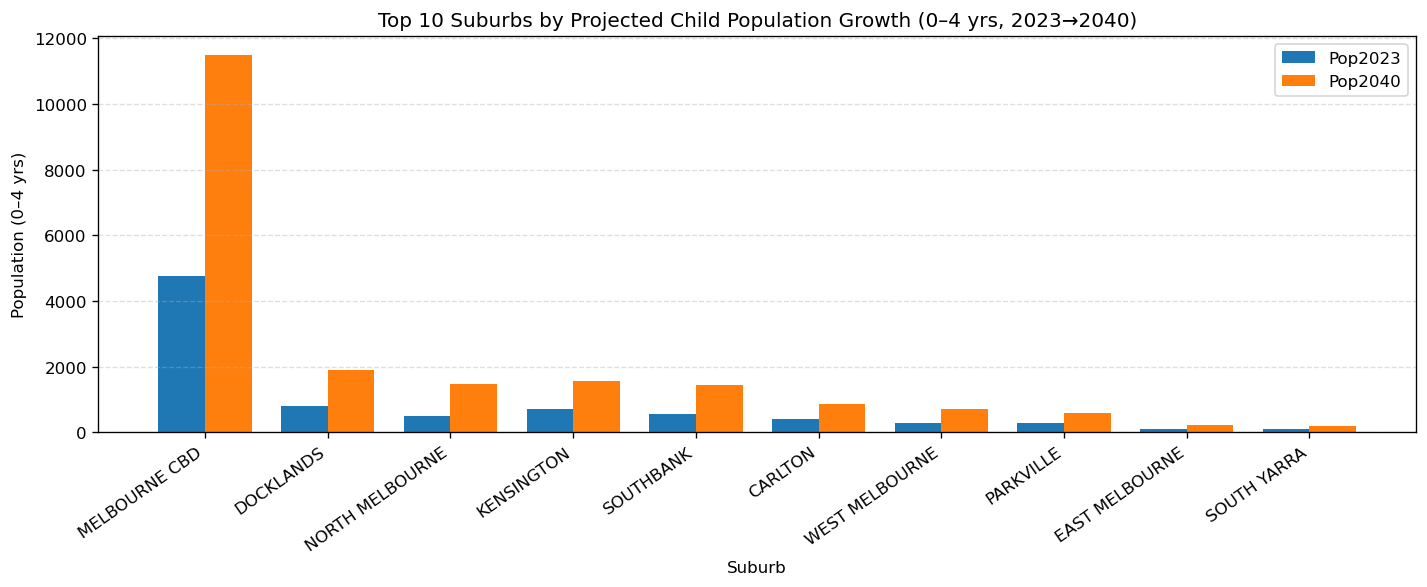

In [40]:
# --- Merge 2023 and 2040 child populations ---
growth_df = pd.merge(pop_2023, pop_2040, on="Suburb", how="inner")
growth_df["AbsoluteGrowth"] = growth_df["Pop2040"] - growth_df["Pop2023"]
growth_df["Growth_%"] = ((growth_df["Pop2040"] - growth_df["Pop2023"]) / growth_df["Pop2023"]) * 100

# --- Top 10 suburbs by absolute growth ---
top_growth = growth_df.sort_values("AbsoluteGrowth", ascending=False).head(10)

# --- Plot (static, HTML-safe) ---
x = np.arange(len(top_growth))        # bar positions
w = 0.38                              # bar width

fig, ax = plt.subplots(figsize=(12, 5), dpi=120)

ax.bar(x - w/2, top_growth["Pop2023"], width=w, label="Pop2023")
ax.bar(x + w/2, top_growth["Pop2040"], width=w, label="Pop2040")

ax.set_title("Top 10 Suburbs by Projected Child Population Growth (0–4 yrs, 2023→2040)")
ax.set_ylabel("Population (0–4 yrs)")
ax.set_xlabel("Suburb")
ax.set_xticks(x)
ax.set_xticklabels(top_growth["Suburb"], rotation=35, ha="right")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

#### Insight: Child Population Growth Hotspots  
Melbourne CBD and Docklands show the highest projected increase in children aged 0–4 by 2040, highlighting urgent pressure on childcare infrastructure.

### Insight 2: Children per Existing Childcare Centre

We join the population growth data with childcare centre counts.  
The code calculates **Future Pressure = Pop2040 ÷ CentreCount**.  
Suburbs are ranked by pressure to show where demand is highest.  
Labels are added to display growth percentages and centre counts.   

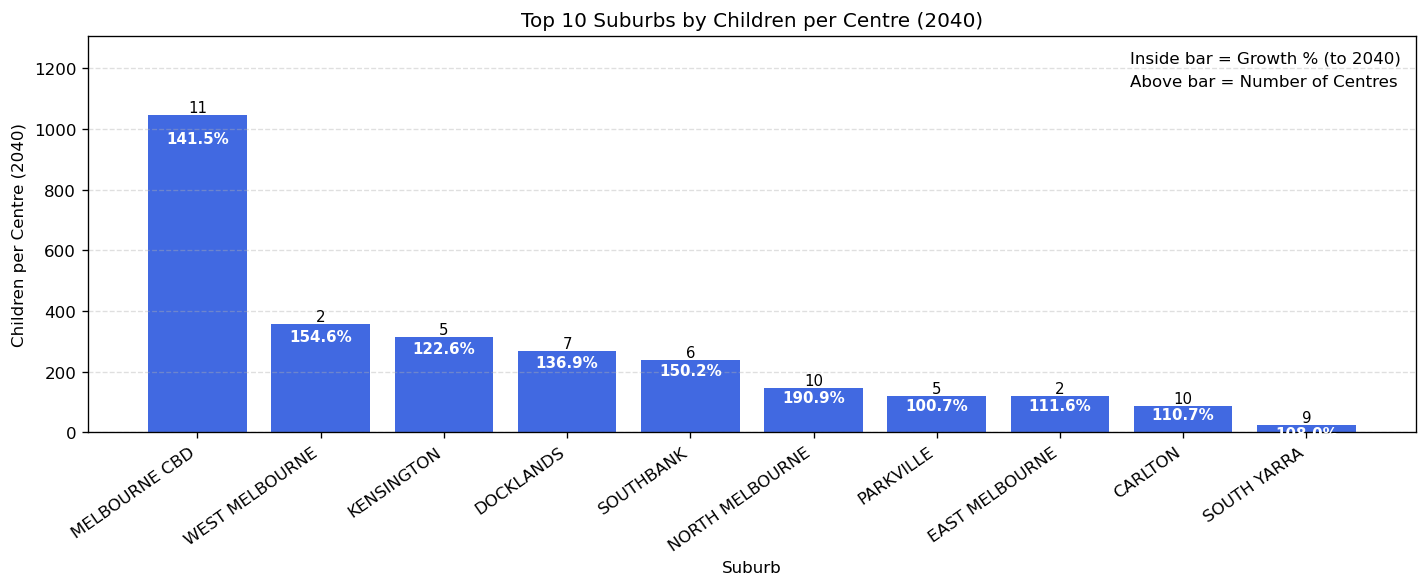

In [41]:
# --- Merge growth data with childcare centres ---
merged_df = pd.merge(growth_df, centre_counts, on="Suburb", how="left").fillna({"CentreCount": 0})
merged_df["Future_Pressure"] = merged_df["Pop2040"] / merged_df["CentreCount"].replace(0, np.nan)

# --- Get top 10 suburbs by future pressure ---
top_pressure = merged_df.sort_values("Future_Pressure", ascending=False).head(10)

# --- Plot ---
fig, ax = plt.subplots(figsize=(12, 5), dpi=120)

bars = ax.bar(top_pressure["Suburb"], top_pressure["Future_Pressure"], color="royalblue")

# Add two labels: one inside (Growth %) and one outside (CentreCount)
for rect, c, g in zip(bars, 
                      top_pressure["CentreCount"].astype(int), 
                      top_pressure["Growth_%"].round(1)):
    height = rect.get_height()
    
    # Growth % inside the bar, near top edge
    ax.text(rect.get_x() + rect.get_width()/2, height*0.95, f"{g}%",
            ha="center", va="top", fontsize=9, color="white", fontweight="bold")
    
    # CentreCount just above the bar
    ax.text(rect.get_x() + rect.get_width()/2, height, f"{c}",
            ha="center", va="bottom", fontsize=9, color="black")

ax.set_title("Top 10 Suburbs by Children per Centre (2040)")
ax.set_ylabel("Children per Centre (2040)")
ax.set_xlabel("Suburb")
ax.set_xticklabels(top_pressure["Suburb"], rotation=35, ha="right")
ax.grid(axis="y", linestyle="--", alpha=0.4)

# Adjust y-limits so outside labels fit
finite_vals = top_pressure["Future_Pressure"].replace([np.inf, -np.inf], np.nan).dropna()
if not finite_vals.empty:
    ax.set_ylim(0, finite_vals.max() * 1.25)

# --- Custom legend ---
legend_elements = [
    mpatches.Patch(color="none", label="Inside bar = Growth % (to 2040)"),
    mpatches.Patch(color="none", label="Above bar = Number of Centres"),
]
ax.legend(handles=legend_elements, loc="upper right", frameon=False)

plt.tight_layout()
plt.show()



#### Insight: Future Pressure on Centres  
By 2040, Melbourne CBD faces the highest childcare pressure with over 1,000 children per centre, far exceeding other suburbs and signalling a critical service gap.

### Insight 3: Centres per 1000 Children (Geospatial Heatmap)

We filter valid **latitude** and longitude values for centres.  
A **Folium map** is created, centred on Melbourne.  
Coordinates are prepared as heatmap data points.  
The heatmap shows clusters where centres are concentrated.  
 


In [42]:
# --- Ensure valid coordinates ---
map_data = supply_df.copy()
pts = map_data[['Latitude', 'Longitude']].dropna()
pts = pts[np.isfinite(pts['Latitude']) & np.isfinite(pts['Longitude'])]

# --- Initialise map centered at Melbourne ---
map1 = folium.Map(location=[-37.8136, 144.9631], zoom_start=12)

# --- Prepare heatmap data ---
heatmap_points = pts[['Latitude', 'Longitude']].values.tolist()

# --- Add HeatMap layer ---
HeatMap(
    data=heatmap_points,
    radius=12,    # size of each point
    blur=15,      # smoothness
    max_zoom=13   # zoom sensitivity
).add_to(map1)

# --- Display map ---
map1



Childcare centres are clustered heavily around the inner city and inner-north (Melbourne, Carlton, Brunswick) and inner-south (St Kilda, Albert Park). Meanwhile, outer suburbs (north, west, east growth areas) show lower density, suggesting these will face greater pressure as child populations grow by 2040

### Insight 4: Service Type Breakdown

We count centres by service type such as **Centre-Based** and **Family Day Care**.  
A bar chart compares the share of each **service category**.  
Colours, labels, and axes are formatted for clarity.  
This highlights which service types dominate across suburbs.  


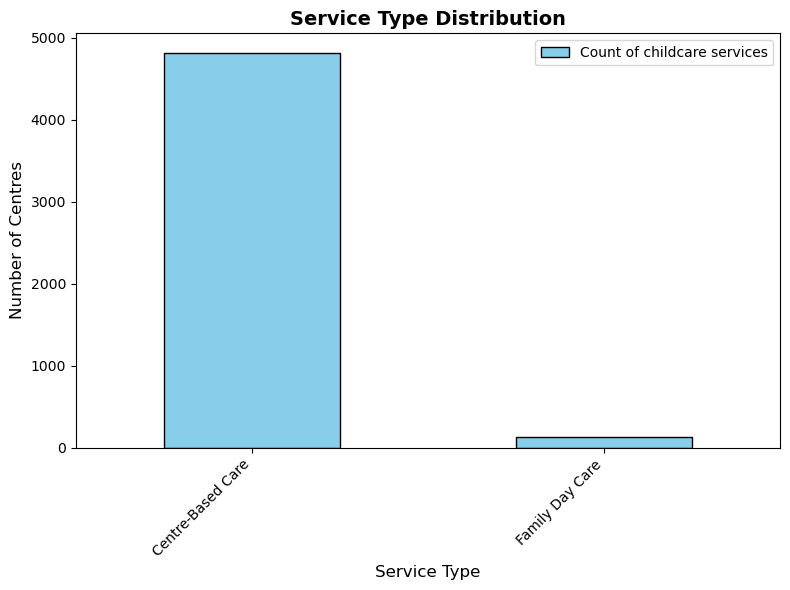

In [43]:
plt.figure(figsize=(8, 6))  # set figure size
supply_df['ServiceType'].value_counts().plot(
    kind='bar',
    color='skyblue',      # bar color
    edgecolor='black'     # adds bar outlines for clarity
)

plt.title('Service Type Distribution', fontsize=14, fontweight='bold')  # title
plt.xlabel('Service Type', fontsize=12)  # x-axis label
plt.ylabel('Number of Centres', fontsize=12)  # y-axis label

plt.xticks(rotation=45, ha='right', fontsize=10)  # rotate + align x labels
plt.yticks(fontsize=10)  # y tick size
plt.legend(["Count of childcare services"])
plt.tight_layout()  # adjust layout to avoid cutoff
plt.show()


#### Insight: Dominance of Centre-Based Care  
Centre-Based Care overwhelmingly dominates childcare provision, while Family Day Care remains a very small proportion of services, highlighting limited diversity in service types.

### Insight 5: Red Flag Suburbs

We identify Suburbs with **high growth** and **high future pressure**.  
Criteria: `Growth_% > 30` **AND** `Future_Pressure > 800`.
A styled table highlights suburbs crossing these limits.  
This reveals the areas most at risk of shortages.  

In [44]:
# --- Order by CentreCount ---
ordered_by_centres = (
    merged_df.sort_values("CentreCount", ascending=False)
    [["Suburb", "Pop2023", "Pop2040", "CentreCount", "Growth_%", "Future_Pressure"]]
    .head(15)
).copy()

# Ensure numeric and keep NaNs as NaN (not strings)
ordered_by_centres["Future_Pressure"] = pd.to_numeric(
    ordered_by_centres["Future_Pressure"], errors="coerce"
)

# --- Threshold for Future Pressure ---
pressure_thresh = 200  # or 800 per your criteria

# --- Highlight only Future_Pressure (skip NaNs) ---
def highlight_pressure(val):
    if pd.isna(val):
        return ""
    return "background-color: red; color: white; font-weight: bold;" if float(val) > pressure_thresh else ""

# --- Styled table ---
styled_centres = (
    ordered_by_centres.style
        .applymap(highlight_pressure, subset=["Future_Pressure"])
        .set_properties(subset=["Suburb"], **{"font-weight": "bold"})
        .format({
            "Growth_%": "{:.1f}%",
            "Future_Pressure": "{:.0f}",
        })
)

print("📈 Top Suburbs by Number of Childcare Centres")
display(styled_centres)



📈 Top Suburbs by Number of Childcare Centres


,Suburb,Pop2023,Pop2040,CentreCount,Growth_%,Future_Pressure
4,MELBOURNE CBD,4762,11498,11,141.5%,1045
0,CARLTON,412,868,10,110.7%,87
5,NORTH MELBOURNE,506,1472,10,190.9%,147
8,SOUTH YARRA,100,208,9,108.0%,23
1,DOCKLANDS,797,1888,7,136.9%,270
7,PORT MELBOURNE,0,76,7,inf%,11
9,SOUTHBANK,574,1436,6,150.2%,239
3,KENSINGTON,709,1578,5,122.6%,316
6,PARKVILLE,296,594,5,100.7%,119
2,EAST MELBOURNE,112,237,2,111.6%,118


#### Insight: Hidden Gaps Despite High Centre Counts  
Even suburbs with a large number of childcare centres, like Melbourne CBD and Docklands, still face severe future pressure due to rapid child population growth, indicating supply isn’t keeping pace with demand.

### Insight 6: Future Centre Shortfalls  
We calculate **children per centre** in 2023 as a baseline.  
The code estimates how many centres are required by **2040**.  
Extra centres needed are derived from this calculation.  
Suburbs are ranked to show the largest expected gaps.  

In [45]:
suburb_baseline = merged_df.copy()

# --- Step 1: Children per centre (2023) for each suburb ---
suburb_baseline["Children_per_Centre_2023"] = (
    suburb_baseline["Pop2023"] / suburb_baseline["CentreCount"].replace(0, pd.NA)
)

# --- Step 2: Expected centres required in 2040 (per suburb) ---
suburb_baseline["Centres_Required_2040"] = (
    suburb_baseline["Pop2040"] / suburb_baseline["Children_per_Centre_2023"]
)

# --- Step 3: Extra centres needed ---
suburb_baseline["Extra_Centres_Needed"] = (
    suburb_baseline["Centres_Required_2040"] - suburb_baseline["CentreCount"]
)

# --- Cleaning ---
suburb_baseline = suburb_baseline.dropna(subset=["Extra_Centres_Needed"])

# --- Step 4: Rank by extra centres needed ---
suburb_needs_sorted = suburb_baseline.sort_values("Extra_Centres_Needed", ascending=False)

# Display top 10
suburb_needs_sorted[["Suburb", "Pop2023", "Pop2040", "CentreCount",
                     "Children_per_Centre_2023", "Extra_Centres_Needed"]].head(10)


,Suburb,Pop2023,Pop2040,CentreCount,Children_per_Centre_2023,Extra_Centres_Needed
7,PORT MELBOURNE,0,76,7,0.000000,inf
5,NORTH MELBOURNE,506,1472,10,50.600000,19.090909
4,MELBOURNE CBD,4762,11498,11,432.909091,15.559849
0,CARLTON,412,868,10,41.200000,11.067961
8,SOUTH YARRA,100,208,9,11.111111,9.720000
1,DOCKLANDS,797,1888,7,113.857143,9.582183
9,SOUTHBANK,574,1436,6,95.666667,9.010453
3,KENSINGTON,709,1578,5,141.800000,6.128350
6,PARKVILLE,296,594,5,59.200000,5.033784
10,WEST MELBOURNE,282,718,2,141.000000,3.092199


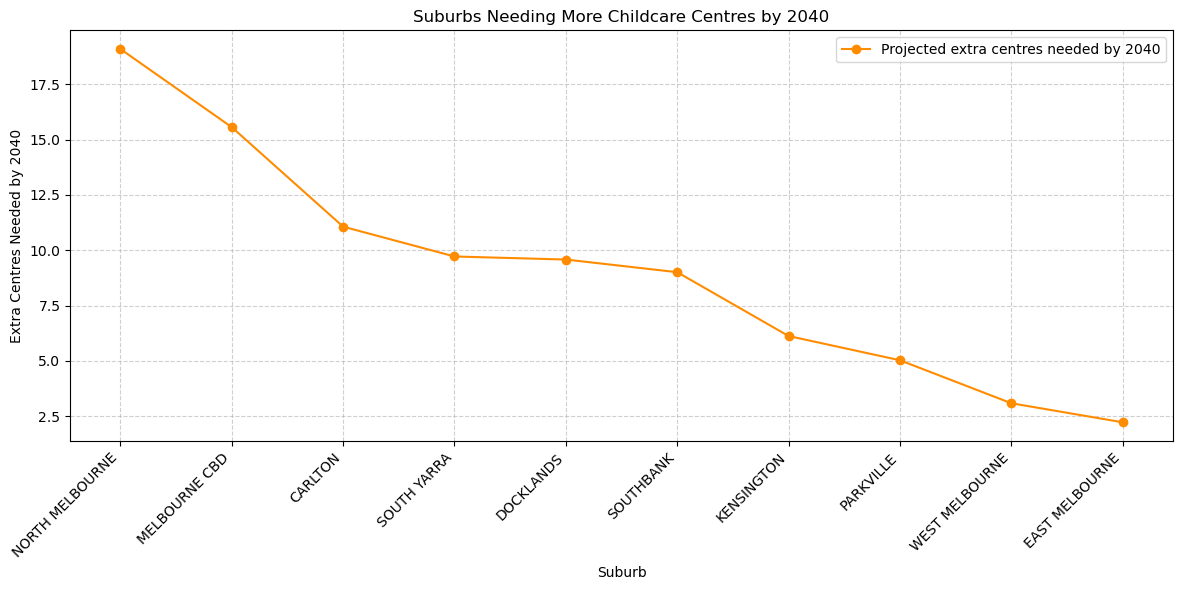

In [46]:
# --- Sort suburbs by extra centres needed ---
sorted_needs = suburb_needs_sorted.head(15)  # top 15 suburbs

# --- Line Plot ---
plt.figure(figsize=(12, 6))
plt.plot(
    sorted_needs["Suburb"],
    sorted_needs["Extra_Centres_Needed"],
    marker="o",
    linestyle="-",
    color="darkorange"
)

plt.xticks(rotation=45, ha="right")
plt.xlabel("Suburb")
plt.ylabel("Extra Centres Needed by 2040")
plt.title("Suburbs Needing More Childcare Centres by 2040")
plt.legend(["Projected extra centres needed by 2040"])
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


#### Insight: Urgent Demand for New Centres  
North Melbourne and Melbourne CBD require the largest number of additional childcare centres by 2040, indicating critical areas where new infrastructure must be prioritised.

### 📍 Childcare Finder Tools – Interactive Search

In this final section, we build **two interactive tools** that allow users to search and explore childcare services.  
The aim is to make the dataset usable for two different groups: **parents** looking for nearby services, and **developers** evaluating where to open new centres.

---

#### Tool 1: Suburb & Service Type Finder
This tool:
- Loads and normalises the childcare centres dataset (suburb and service type names).  
- Provides two dropdown menus: one for selecting a suburb and another for selecting a service type.  
- When the user clicks **Search**, it filters the dataset to show only the relevant centres.  
- The results are displayed in a clean table with key details: service name, type, address, suburb, and phone (if available).  

**Why this is useful:**  
Parents or planners can quickly see all services of a given type in their suburb, without manually scanning the dataset.


In [47]:
# --- Tool 1: Suburb & Service Type Filter ---
def tool1_find_childcare_centres():
    # Load dataset from local repo file
    df = pd.read_csv("geocoded_output.csv")
    df.columns = df.columns.str.strip()

    # Normalise text fields
    for col in ["Suburb", "ServiceType"]:
        if col in df.columns:
            df[col] = df[col].astype(str).str.strip().str.upper()

    # sanity check
    need = {"Suburb", "ServiceType"}
    if not need.issubset(df.columns):
        raise ValueError(f"Dataset missing columns: {sorted(list(need - set(df.columns)))}")

    # Dropdowns
    suburb_dropdown = widgets.Dropdown(
        options=sorted([s for s in df["Suburb"].dropna().unique() if s]),
        description="Suburb:",
        layout=widgets.Layout(width='400px')
    )
    service_dropdown = widgets.Dropdown(
        options=sorted([s for s in df["ServiceType"].dropna().unique() if s]),
        description="Service Type:",
        layout=widgets.Layout(width='400px')
    )

    output = widgets.Output()

    def on_button_click(_):
        with output:
            clear_output()
            selected_suburb = suburb_dropdown.value
            selected_service = service_dropdown.value

            filtered = df[(df["Suburb"] == selected_suburb) & (df["ServiceType"] == selected_service)].copy()

            if not filtered.empty:
                cols = [c for c in ["ServiceName", "ServiceType", "Address", "Suburb", "Phone"] if c in filtered.columns]
                print(f"\nFound {len(filtered)} centres in {selected_suburb} for {selected_service}:\n")
                display(filtered[cols].reset_index(drop=True))
            else:
                print("\nSorry, no matching centres found.")

    search_button = widgets.Button(
        description="Search Centres", button_style='success',
        layout=widgets.Layout(width='200px')
    )
    search_button.on_click(on_button_click)

    display(suburb_dropdown, service_dropdown, search_button, output)

# Run Tool 1 UI
tool1_find_childcare_centres()


Dropdown(description='Suburb:', layout=Layout(width='400px'), options=('ABBOTSFORD', 'ABERFELDIE', 'AINTREE', …

Dropdown(description='Service Type:', layout=Layout(width='400px'), options=('CENTRE-BASED CARE', 'FAMILY DAY …

Button(button_style='success', description='Search Centres', layout=Layout(width='200px'), style=ButtonStyle()…

Output()

#### Tool 2: Nearest Centre Locator
This tool is more advanced and supports two user roles: **Parent** and **Developer**.

- **User interface:**  
  - A role toggle (Parent or Developer).  
  - Dropdown menus to select suburb and service type.  
  - A text box for entering an address.  

- **How it works:**  
  1. The address entered by the user is geocoded (converted into latitude/longitude).  
  2. The dataset is filtered by the selected suburb and service type.  
  3. Distances between the input address and each centre are calculated using the **geodesic method**.  
  4. Results are sorted from nearest to farthest.  

- **Role-specific outputs:**  
  - *Parent:* Displays the single nearest centre with name, type, address, and distance.  
  - *Developer:* Displays the three nearest centres, with distance quality labels (e.g., within 1 km = **Not Advisable**, beyond 2 km = **Advisable**).  

**Why this is useful:**  
- Parents can immediately find the closest service that matches their needs.  
- Developers can quickly check how competitive an area already is before planning new sites.  


In [48]:
# --- Tool 2: Nearest Centre Locator (Parent / Developer) ---
# thresholds
NOT_ADVISABLE_KM = 1.0
ADVISABLE_KM = 2.0

def tool2_nearest_centre_locator():
    # Load & clean
    df = pd.read_csv("geocoded_output.csv")
    df.columns = df.columns.str.strip()
    
    # required columns
    need = {"Latitude","Longitude","Suburb","ServiceType"}
    if not need.issubset(df.columns):
        raise ValueError(f"Dataset missing columns: {sorted(list(need - set(df.columns)))}")

    # numeric coords
    df["Latitude"]  = pd.to_numeric(df["Latitude"], errors="coerce")
    df["Longitude"] = pd.to_numeric(df["Longitude"], errors="coerce")
    df = df.dropna(subset=["Latitude","Longitude"]).copy()

    # normalise text
    for col in ["Suburb","ServiceType"]:
        df[col] = df[col].astype(str).str.strip().str.upper()

    # Widgets
    role_toggle = widgets.ToggleButtons(
        options=["Parent", "Developer"],
        description="I am a:",
        style={'description_width': 'initial'}
    )
    suburb_dropdown = widgets.Dropdown(
        options=sorted([s for s in df["Suburb"].dropna().unique() if s]),
        description="Suburb:",
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='50%')
    )
    service_dropdown = widgets.Dropdown(
        options=sorted([s for s in df["ServiceType"].dropna().unique() if s]),
        description="Service Type:",
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='50%')
    )
    address_input = widgets.Text(
        placeholder='Enter your address (e.g. 123 Swanston St, MELBOURNE)',
        description='Your Address:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='70%')
    )
    submit_button = widgets.Button(description="Find Nearest Centre(s)", button_style='success')
    output = widgets.Output()

    # Update address label/placeholder when role changes
    def _on_role_change(change):
        if change["name"] == "value":
            if change["new"] == "Developer":
                address_input.description = "Project Address:"
                address_input.placeholder = "Enter proposed site address (e.g. 123 Swanston St, MELBOURNE)"
            else:
                address_input.description = "Your Address:"
                address_input.placeholder = "Enter your address (e.g. 123 Swanston St, MELBOURNE)"
    role_toggle.observe(_on_role_change, names="value")

    def advisability_label(dist_km: float) -> str:
        try:
            d = float(dist_km)
        except Exception:
            return ""
        if d < NOT_ADVISABLE_KM:
            return f"Not advisable (nearest < {NOT_ADVISABLE_KM:.1f} km)"
        elif d > ADVISABLE_KM:
            return f"Advisable (nearest > {ADVISABLE_KM:.1f} km)"
        else:
            return f"Borderline (nearest {NOT_ADVISABLE_KM:.1f}–{ADVISABLE_KM:.1f} km)"

    def _find(_):
        with output:
            clear_output()

            if not address_input.value.strip():
                print("❌ Please enter an address.")
                return

            # Geocode
            try:
                geolocator = Nominatim(user_agent="childcare_locator_demo")
                location = geolocator.geocode(address_input.value.strip(), timeout=15)
            except Exception as e:
                print(f"❌ Geocoding failed: {e}")
                return

            if location is None:
                print("❌ Could not geocode your address. Please try again or be more specific.")
                return

            user_coords = (location.latitude, location.longitude)

            # Filter by Suburb & ServiceType
            filtered = df[(df["Suburb"] == suburb_dropdown.value) &
                          (df["ServiceType"] == service_dropdown.value)].copy()
            if filtered.empty:
                print("❌ No childcare centres found for this suburb + service type.")
                return

            # Compute distances
            filtered = filtered.copy()
            filtered["Distance_km"] = filtered.apply(
                lambda r: geodesic(user_coords, (r["Latitude"], r["Longitude"])).km,
                axis=1
            )
            filtered = filtered.sort_values("Distance_km").reset_index(drop=True)

            role = role_toggle.value
            if role == "Developer":
                top_n = 3
                nearest_rows = filtered.head(top_n).copy()
                nearest_rows["Advisability"] = nearest_rows["Distance_km"].map(advisability_label)

                nearest = nearest_rows.iloc[0]
                print(f"✅ Nearest centre is {nearest.get('ServiceName','(Unnamed)')} at {nearest['Distance_km']:.2f} km — {advisability_label(nearest['Distance_km'])}\n")

                cols = [c for c in ["ServiceName","ServiceType","Address","Suburb","Phone","Distance_km","Advisability"] if c in nearest_rows.columns]
                display(nearest_rows[cols])
            else:
                nearest = filtered.iloc[0]
                print("✅ Nearest Centre")
                print(f"   • Name: {nearest.get('ServiceName','(Unnamed)')}")
                print(f"   • Address: {nearest.get('Address','N/A')}, {nearest.get('Suburb','')}")
                print(f"   • Phone: {nearest.get('Phone','N/A')}")
                print(f"   • Distance: {nearest['Distance_km']:.2f} km")

    submit_button.on_click(_find)

    display(widgets.VBox([role_toggle, suburb_dropdown, service_dropdown, address_input, submit_button, output]))

# Run Tool 2 UI
tool2_nearest_centre_locator()


## Conclusion & Next Steps

**What we learned:**  
This analysis showed that the **0–4 population** in Melbourne will grow unevenly between 2023 and 2040.  
Some suburbs, like **Docklands** and **Melbourne CBD**, will see the largest increases.  
By linking demand with current **centre counts**, we identified suburbs where **future pressure** will be highest.  
The heatmap confirmed that centres are **clustered in inner areas**, while the service type breakdown revealed a **dominance of centre-based care**.  
Red flag suburbs and shortfall estimates highlighted **where new centres are urgently needed**.  

**Key takeaways from the code:**  
- Successfully **merged and cleaned datasets** (population forecasts and childcare centres).  
- Calculated **absolute growth, growth percentages, and future pressure** for each suburb.  
- Built multiple **visualisations** (growth charts, pressure plots, heatmaps, service type distribution) to interpret demand vs supply.  
- Implemented **interactive tools**:  
  - Tool 1: Suburb & Service Type Finder to filter centres by location and type.  
  - Tool 2: Nearest Centre Locator using **geocoding and distance calculations** for parents and developers.  

**Operational takeaways:**  
- Suburbs with **high growth and high pressure** must be prioritised for planning.  
- Areas with an **imbalanced service mix** may benefit from targeted expansion.  
- The interactive **Childcare Finder tools** make these insights actionable for both parents and developers.  

**Assumptions and caveats:**  
- Supply is measured by **number of centres**, not licensed places or capacity.  
- Forecasts do not account for **policy shifts, new developments, or closures**.  

**Next steps:**  
1. Add licensed **capacity and operating hours** to refine shortfall estimates.  
2. Include **transport and accessibility layers** (e.g., tram and bus stops, walkability).  
3. Package the tools into a **user-friendly web app** for broader access.  

By combining forecasts with supply data and providing interactive tools, this project delivers a **decision-ready foundation** for smarter childcare planning in Melbourne.  
